# Analyzing the JWST Pipeline products of HAT-P-1b observations with NIRISS/SOSS
--------------------------------------------------------------
**Author**: Néstor Espinoza (nespinoza@stsci.edu) | **Latest update**: July 6, 2020.

## Table of contents
1. [Introduction](#intro)
2. [Spectral extraction](#extraction)
   1. [Tracing the orders](#tracing)
   2. [Extracting the spectra](#extracting)
   3. [Time-stamps and wavelength solution](#timenwavelength)
3. [Fitting & analyzing white-light lightcurves](#white-light)
   1. [Studying the residuals](#wl-residuals)
4. [Fitting & analyzing the wavelength-dependant lightcurves](#wavelength)
5. [Studying the transit spectrum of HAT-P-1b](#transit-spectra)

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------
In the previous notebooks, we simulated data for NIRISS/SOSS observations targeting a transit of HAT-P-1b, and calibrated the simulated data using the JWST pipeline. In this notebook, we analyze some of the products of the JWST pipeline in order to analyze the transmission spectrum of the exoplanet.
   
At the day of writing of this notebook, the JWST calibration pipeline does not have a spectral extraction algorithm that can deal with the complicated structure of NIRISS/SOSS data. In particular, the `SUBSTRIP256` subarray has data from at least two NIRISS/SOSS orders, which overlap at the reddest wavelengths. An algorithm to properly extract this data is on-the-making, but in this notebook we will be performing our own tracing and extraction of the spectra in order to showcase how to analyze the JWST products. After extracting the spectrum, we will generate the white-light lightcurves of each order, fit them and compare the extracted parameters to the ones in the literature. Then, we will repeat the procedures for the wavelength-dependant lightcurves, with which we will get the transmission spectrum of the exoplanet. 

Before we begin, let's import some libraries:

In [174]:
# General internal libraries:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from numpy.polynomial import chebyshev

# Libraries for plotting, reading data:
import seaborn as sns 
from astropy.io import fits

# Juliet (for transit fitting & model evaluation:)
import juliet

2.<font color='white'>-</font>Spectral extraction <a class="anchor" id="extraction"></a>
--------------------------------------------------------------------
### A.<font color='white'>-</font>Tracing the orders<a class="anchor" id="tracing"></a>
Before we can go ahead and perform spectral extraction of the orders, we need to trace them in order to guide the spectral extraction algorithm on where the spectrum is. Let's first do some data exploration to understand how we might do this with the complicated spectral profile of NIRISS/SOSS. Let's first extract the `rateint` products:

In [173]:
data = fits.getdata('data_new_rateints.fits')

There are several ways moving forward to trace the spectrum. In theory, when JWST is on the sky, precise shapes and positions will be available, and we could use those. We could also trace each integration individually, in order to check for possible movements/shape changes of the trace during the observations. As a first order approach to the problem, let's try to find a representative trace for all the integrations. To this end, let's generate a "median" image by collapsing all the products in time, so as to have a view of the "average" shape of the traces along the entire exposure:

In [25]:
median_image = np.median(data,axis=0)

Let's plot it:

Text(0, 0.5, 'Rates (e-/s)')

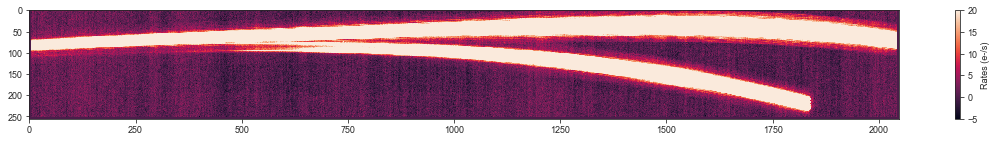

In [26]:
plt.figure(figsize=(20,2))
im = plt.imshow(median_image)
im.set_clim(-5,20)
cb = plt.colorbar()
cb.ax.set_ylabel('Rates (e-/s)')

This plot tells us a lot about how to move forward with the data analysis in general of this dataset. For example, note that although the pipeline has done a good job at removing structure in the data, there are is still some structure which appear as vertical strips. This is a well known pattern due to the readout of IR detectors which is typically identified as "1/f noise". By eye it seems some simple column-by-column background substraction should take care of that.

On top of this, this image tells us a little bit of the care we have to have with tracing. For example, spectra of order 1 and 2 start to overlap around pixel ~750. In addition, we can see how the right side of both traces are the ones that have the most signal, which decreases to the left-hand side (redder wavelengths). Let's use all this to our advantage to trace the spectra. First, let's write a small script to get the centroids of each column for each order. Here we'll use a very simple algorithm in which we convolve each column with a gaussian filter (in order to smooth the profile, which is rather complex), and then take the centroiding of that filtered image. We repeat this procedure in each of the columns of the image in order to obtain the centroids of the traces, and then we fit them with a polynomial:

In [27]:
from scipy.ndimage import gaussian_filter1d
def trace_spectrum(image, xstart, ystart, profile_radius = 20, gauss_filter_width = 10):
    """
    Function that non-parametrically traces NIRISS/SOSS spectra. First, to get the centroid at xstart and 
    ystart, it convolves the spatial profile with a gaussian filter, finding its peak through usual flux-weighted 
    centroiding. Next, it uses a smoothed shape in this column to find the centroid of the next, left column, 
    through cross-correlation of that shape.
    
    Parameters
    ----------
    image: ndarray
        The image that wants to be traced.
    xstart: float
        The x-position (column) on which the tracing algorithm will be started
    ystart: float
        The estimated y-position (row) of the center of the trace. An estimate within 10-20 pixels is enough.
    profile_radius: float
        Expected radius of the profile measured from its center. Only this region will be used to estimate 
        the centroids of the spectrum.
    gauss_filter_width: float
        Width of the gaussian filter used to perform the centroiding of the first column
    """
    # Define x-axis:
    x = np.arange(0,xstart)
    # Define y-axis:
    y = np.arange(image.shape[0])
    # Define array that will save centroids at each x:
    ycentroids = np.zeros(len(x))
    for i in range(len(x))[::-1]:
        xcurrent = x[i]
        # Convolve column with a gaussian filter; remove median before convolving:
        filtered_column = gaussian_filter1d(image[:,xcurrent] - np.median(image[:,xcurrent]), gauss_filter_width)
        # Find centroid within profile_radius pixels of the initial guess:
        idx = np.where(np.abs(y-ystart)<profile_radius)[0]
        ycentroids[i] = np.sum(y[idx]*filtered_column[idx])/np.sum(filtered_column[idx])
        ystart = ycentroids[i]
    # Check for nans:
    idx = np.where(~np.isnan(ycentroids))
    return x[idx],ycentroids[idx]

Let's try our algorithm first for order 1 (the one on the top). Let's start it on column 2043 which, by eye, has the center of the profile around pixel 70:

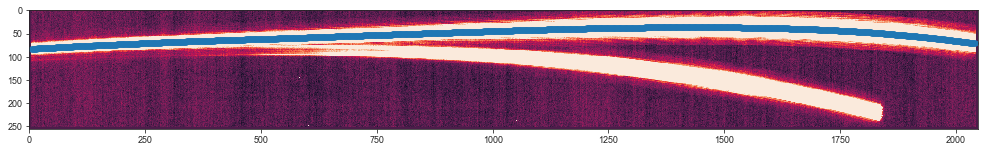

In [28]:
x1,y1 = trace_spectrum(median_image, 2043, 70)
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
plt.plot(x1,y1,'o')

Woah, pretty good for such a simple approach! Let's fit a Chebyshev polynomial for all the data so we can smooth this shape a little bit. To select the best order for this polynomial, let's write a small function that does model selection using the BIC. 

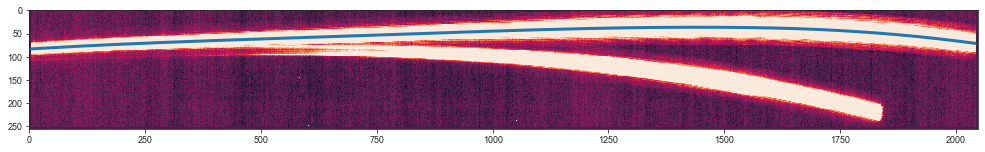

In [29]:
def select_cheby_order(x,y,min_order,max_order):
    """
    This function selects (and returns) the optimal order of a Chebyshev polynomial using the BIC.
    
    Parameters
    ----------
    x: ndarray
        Array with the regressors
    y: ndarray
        Array with the data
    min_order: int
        Minimum order to try
    max_order: int
        Maximum order to try
    """
    orders = np.arange(min_order,max_order)
    bics = np.zeros(len(orders))
    n = len(x)
    for i in range(len(orders)):
        order = orders[i]
        coeffs = chebyshev.chebfit(x,y,deg=order)
        RSS = np.sum((y - chebyshev.chebval(x,coeffs))**2)
        bics[i] = n*np.log(RSS/n) + (order+1)*np.log(n)
    idx = np.where(np.min(bics) == bics)[0]
    return orders[idx][0]

# Try orders from 1 to 30 in the polynomial:
order = select_cheby_order(x1,y1,1,30)
# Use the best-one as deemed by the BIC
coeffs1 = chebyshev.chebfit(x1,y1,deg=order)
# Plot:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
plt.plot(x1,chebyshev.chebval(x1,coeffs1),lw=3)

That's pretty good! 

Now, we can see how the same procedure is deemed to fail for order 2 (the lower trace) for columns below around 1000. This is because this order quickly starts to overlap with order 1 below this. We will help our algorithm a little bit then by masking the upper trace. To this end, we will use the same algorithm for obtaining the centroids of the trace but will pass a masked image, containing only the lower trace. To do this, we will multiply all the values below row 80 (i.e., the upper pixels in the plot above) by zero. 

We'll start our algorithm in column 1839 (the edge of the trace here), which has its centroid, by eye, around row 225. Let's see how we do:

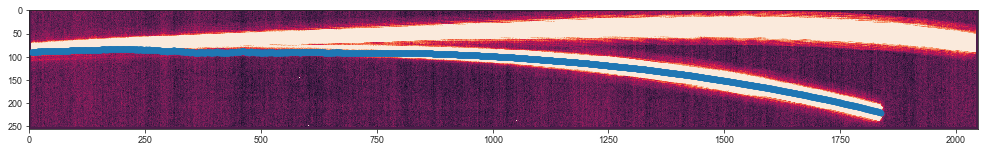

In [30]:
mask = np.zeros(median_image.shape)
mask[80:,:] = np.ones(mask[80:,:].shape)
x2,y2 = trace_spectrum(median_image*mask, 1839, 225)
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
plt.plot(x2,y2,'o')

Not bad! Let's smooth the trace, as done for Order 1, with a Chebyshev polynomial. Here it seems the centroiding is OK for columns above 750 --- and also, is only up to this wavelength that we would trust aperture extraction on this order, so let's only fit/use that part of the trace and pixels above it:

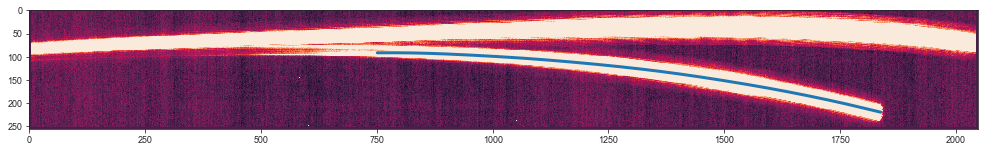

In [31]:
idx = np.where(x2>750)[0]
x2,y2 = x2[idx],y2[idx]
# Try orders from 1 to 30 in the polynomial:
order = select_cheby_order(x2,y2,1,30)
# Use the best-one as deemed by the BIC
coeffs2 = chebyshev.chebfit(x2,y2,deg=order)
# Plot:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
plt.plot(x2,chebyshev.chebval(x2,coeffs2),lw=3)

Now let's plot both, the traces for order 1 and 2 together in a final plot:

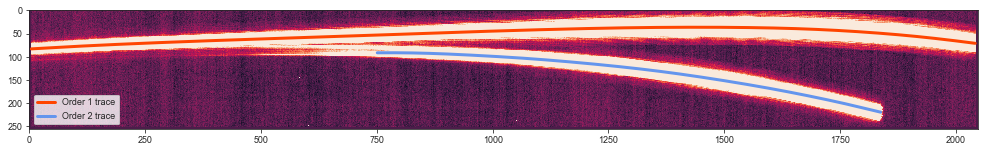

In [32]:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
plt.plot(x1,chebyshev.chebval(x1,coeffs1),lw=3,label='Order 1 trace', color = 'orangered')
plt.plot(x2,chebyshev.chebval(x2,coeffs2),lw=3,label='Order 2 trace', color = 'cornflowerblue')
plt.legend()

That's pretty good for such a simple procedure! 

Because the objective of this notebook is to do simple aperture extraction, from here on we will assume this trace applies to all the individual integrations. In reality, one would want to trace every integration separately in order to look for possible shape changes in the trace during the exposure, or position shifts which are useful for decorrelating the transit lightcurves --- this could be easily done with our algorithms above by just iterating through each integration. Here, however, the objective is to show users how to deal with JWST data with a simple approach --- so we proceed with these caveats in mind.

### B.<font color='white'>-</font>Extracting the spectra<a class="anchor" id="extracting"></a>

With our traces at hand, we can now perform simple extraction of the spectra on each integration. Let's write a small script that is able to do simple aperture extraction given a set of `x` and `y` coordinates that follow the trace, and loop that through all of our integrations. First, the aperture extraction function:

In [33]:
def aperture_extraction(image, x, y, aperture_radius, background_radius):
    """
    This function takes as inputs two arrays (x,y) that follow the trace, 
    and returns the added flux over the defined aperture radius, substracting in the way 
    any background between the aperture radius and the background radius. The background is 
    calculated by taking the median of the points between the aperture_radius and the background_radius.
    
    Parameters
    ----------
    image: ndarray
        Image from which the spectrum wants to be extracted
    x: ndarray
        Array with the x-axis of the trace (i.e., the columns, wavelength direction)
    y: ndarray
        Array with the y-axis of the trace (i.e., rows, spatial direction)
    aperture_radius: float
        Distance from the center of the trace at which you want to add fluxes.
    background_radius: float
        Distance from the center of the trace from which you want to calculate the background. 
    """
    # Create array that will save our fluxes:
    flux = np.zeros(len(x))
    max_column = image.shape[0]
    for i in range(len(x)):
        # Cut the column with which we'll be working with:
        column = image[:,int(x[i])]
        # Define limits given by the aperture_radius and background_radius variables:
        left_side_bkg = y[i]-background_radius
        right_side_bkg = y[i]+background_radius
        left_side_ap = y[i]-aperture_radius
        right_side_ap = y[i]+aperture_radius
        # Extract background, being careful with edges:
        bkg_left = column[np.max([0,int(left_side_bkg)]):np.max([0,int(left_side_ap)])]
        bkg_right = column[np.min([int(right_side_ap),max_column]):np.max([int(right_side_bkg),max_column])]
        bkg = np.median(np.append(bkg_left,bkg_right))
        # Substract it from the column:
        column -= bkg
        # Perform aperture extraction of the background-substracted column, being careful with pixelization 
        # at the edges. First, deal with left side:
        l_decimal, l_integer = np.modf(left_side_ap)
        l_integer = int(l_integer)
        if l_decimal < 0.5:
            l_fraction = (0.5-l_decimal)*column[l_integer]
            l_limit = l_integer+1
        else:
            l_fraction = (1. - (l_decimal-0.5))*column[l_integer+1]
            l_limit = l_integer+2
        # Now right side:
        r_decimal, r_integer = np.modf(right_side_ap)
        r_integer = int(r_integer)
        if r_decimal < 0.5:
            r_fraction = (1. - (0.5-r_decimal))*column[r_integer]
            r_limit = r_integer
        else:
            r_fraction = (r_decimal-0.5)*column[r_integer+1]
            r_limit = r_integer+1
        # Save total flux in current column:
        flux[i] = l_fraction + r_fraction + np.sum(column[l_limit:r_limit])
    return flux

Let us now extract the spectra. To this end, we have to define an aperture extraction --- we decide to use a 30-pixel aperture extraction, and a 50-pixel background radius. As shown in the following plot, these regions cover both the spectra and also a big chunk of the background region(s): 

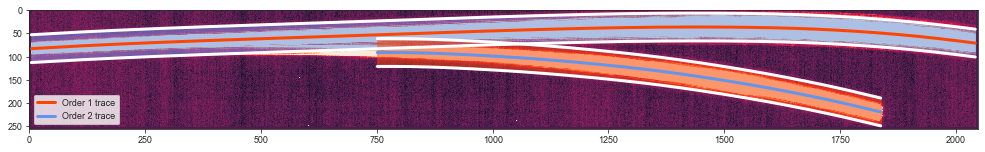

In [34]:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
plt.plot(x1,chebyshev.chebval(x1,coeffs1),lw=3,label='Order 1 trace',color='orangered')
plt.plot(x2,chebyshev.chebval(x2,coeffs2),lw=3,label='Order 2 trace',color='cornflowerblue')
for xn,coeffs in zip([x1,x2],[coeffs1,coeffs2]):
    plt.plot(xn,chebyshev.chebval(xn,coeffs)+30,'w-',lw=3)
    plt.plot(xn,chebyshev.chebval(xn,coeffs)-30,'w-',lw=3)
plt.fill_between(x1,chebyshev.chebval(x1,coeffs1)+30,chebyshev.chebval(x1,coeffs1)-30,
                 color='cornflowerblue',alpha=0.5)
plt.fill_between(x2,chebyshev.chebval(x2,coeffs2)+30,chebyshev.chebval(x2,coeffs2)-30,
                 color='orangered',alpha=0.5)
plt.ylim(data.shape[1],0)
plt.legend()

Now let's loop over all the integrations, extract the spectra of both orders, and save that to some dictionaries. We will save both the spectra and the columns, so we can later relate the latter to wavelength-space:

In [35]:
spectra = {}
spectra['order1'], spectra['order2'] = {}, {}
spectra['order1']['x'], spectra['order2']['x'] = x1, x2
spectra['order1']['flux'], spectra['order2']['flux'] = np.zeros([data.shape[0], len(x1)]),\
                                                       np.zeros([data.shape[0], len(x2)])

for i in range(data.shape[0]):
    spectra['order1']['flux'][i,:] = aperture_extraction(data[i,:,:],x1,y1,30,50)
    spectra['order2']['flux'][i,:] = aperture_extraction(data[i,:,:],x2,y2,30,50)

Finally, let's plot the spectra of the first 100 integrations to see how we did:

Text(0, 0.5, 'e-/s')

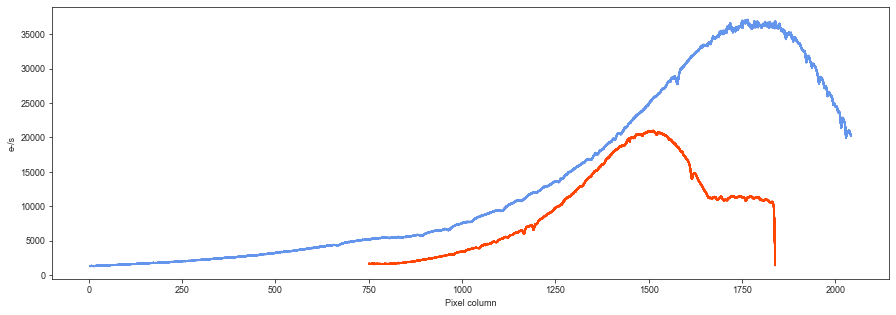

In [36]:
plt.figure(figsize=(15,5))
for i in range(100):
    plt.plot(spectra['order1']['x'], spectra['order1']['flux'][i,:], color = 'cornflowerblue',alpha = 0.5)
    plt.plot(spectra['order2']['x'], spectra['order2']['flux'][i,:], color = 'orangered',alpha = 0.5)
plt.xlabel('Pixel column')
plt.ylabel('e-/s')

This is pretty good! It is interesting to see how we can actually identify where the contamination from the second order kicks in in the Order 1 spectra (blue) around pixel ~750. This is actually evident from the images above, and something to keep in mind when performing analyses with this data. 

**[Developer note: the flattening of the spectral shape for pixels above ~1700 in Order 2 is most likely a bug from the awesimsoss simulator. We'll be working to fix this.]**

### C.<font color='white'>-</font>Time-stamps and wavelength solution<a class="anchor" id="timenwavelength"></a>

Before continuing to the next step, we need to extract two extra data products that will become useful in our analyses in this notebook: (a) the time-stamps of each integration and (b) the wavelength solution corresponding to each pixel in the frame for Order 1 and Order 2. The first is the easiest to extract, as they are in the `*rateints.fits` products. Let's extract those and save them to our dictionary:


In [37]:
# In theory this is as easy as: 
# hdul = fits.open('data_rateints.fits') 
# t = hdul[4].data['int_mid_BJD_TDB']
# But for some reason I can't seem to extract this (not being saved to the rateints products).
t = np.load('times.npy')
spectra['times'] = t

**[Developer note: we are tracking the above failure in the JWST pipeline to an error on the awesimsoss simulator]**

We now turn to the wavelength solution of NIRISS/SOSS. This, in theory, will be obtained from a wavelength map such that there is a wavelength associated to every pixel in NIRISS/SOSS for each order. The current wavelength map (and the one used to generate the simulations presented here) has been attached as part of this notebook --- here we trim it to match the SUBSTRIP256 ranges:

Text(0, 0.5, 'Wavelength')

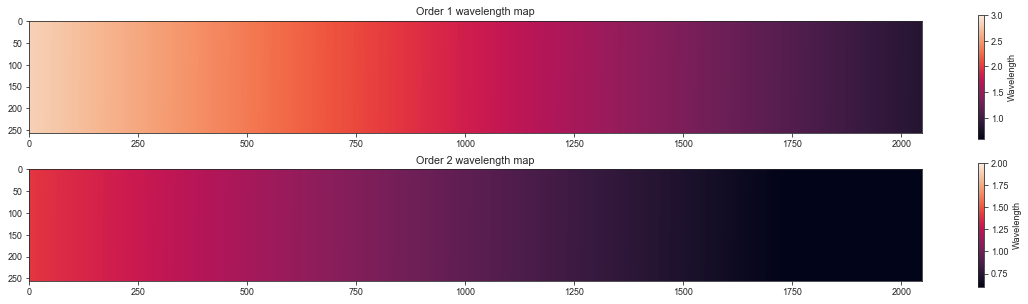

In [38]:
wmap = fits.getdata('soss_wavelengths_fullframe.fits').swapaxes(-2, -1)[:,slice(0,256),::-1]
plt.figure(figsize=(20,5))
plt.subplot(211)
plt.title('Order 1 wavelength map')
im = plt.imshow(wmap[0,:,:])
im.set_clim(0.6,3.0)
cb = plt.colorbar()
cb.ax.set_ylabel('Wavelength')
plt.subplot(212)
plt.title('Order 2 wavelength map')
im = plt.imshow(wmap[1,:,:])
im.set_clim(0.6,2.0)
cb = plt.colorbar()
cb.ax.set_ylabel('Wavelength')

One important caveat to have in mind is that the wavelength maps are not strictly vertical, i.e., wavelengths do not align perfectly with the columns. An easy way to see this is to have an image showing "iso-wavelength" bands --- identify pixels that have the same wavelengths and "paint" them in a plot. Let's do this for Order 1:

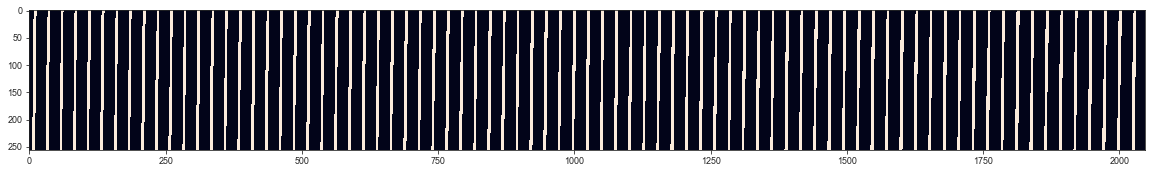

In [39]:
plt.figure(figsize=(20,25))
Z = np.zeros(wmap[0,:,:].shape)
for w in np.linspace(0.5,3.,100):
    wmin,wmax = w,w+0.005
    idx = (wmap[0,:,:]>wmin)&(wmap[0,:,:]<wmax)
    Z[idx] = 1.
plt.imshow(Z,interpolation=None)

As can be seen from these maps, this is not extremely critical for NIRISS/SOSS (iso-wavelength bands span ~3-5 pixels), but it might be important for precise, higher-resolution work to take this into account in the extraction. For our application here, however, we simply take the average wavelength value per column to associate wavelengths with pixels for each order, and we save that to our dictionary:

In [40]:
avg_waves = np.mean(wmap,axis=1)
spectra['order1']['w'], spectra['order2']['w'] = avg_waves[0,spectra['order1']['x']],\
                                                 avg_waves[1,spectra['order2']['x']]  

Let's have a final look at the extracted spectra, but now with these wavelengths as x-axis instead of the pixel columns:

Text(0, 0.5, 'e-/s')

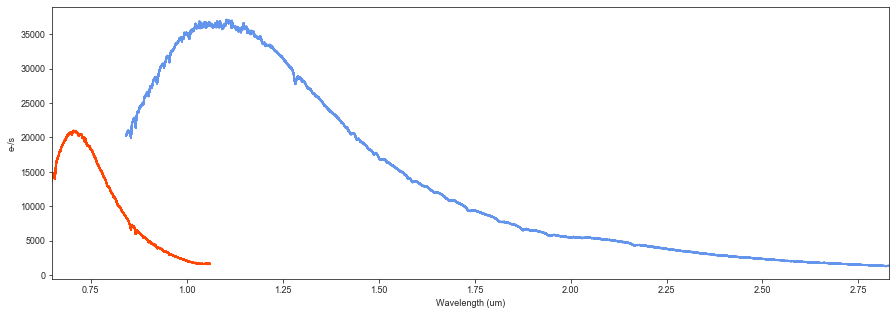

In [50]:
plt.figure(figsize=(15,5))
for i in range(100):
    plt.plot(spectra['order1']['w'], spectra['order1']['flux'][i,:], color = 'cornflowerblue',alpha = 0.5)
    plt.plot(spectra['order2']['w'], spectra['order2']['flux'][i,:], color = 'orangered',alpha = 0.5)
plt.xlabel('Wavelength (um)')
plt.xlim([0.65,2.83])
plt.ylabel('e-/s')

That looks pretty good! Having our completed/reduced dataset, we proceed to save our pickle file in order to keep working with this in the next sections:

In [51]:
pickle.dump(spectra, open('spectra.pkl','wb'))

**[Developer note: on the final iteration of this notebook, these pickle dumps should be removed]**

3.<font color='white'>-</font>Fitting & analyzing white-light lightcurves<a class="anchor" id="white-light"></a>
---------------------------------------------------------------------------------------

Having extracted our spectra, we are ready to jump into the "fun" part of this notebook: the analyses of actual simulated NIRISS/SOSS transit lightcurves. Let's first create the white-light lightcurves of both Order 1 and Order 2 by summing the spectra extracted in the previous section, but on regions on which we *know* there will be _no_ contamination from overlapping orders. This step is important because the white-light lightcurves help determine the most precise transit parameters for the wavelength-dependant lightcurves, and thus we want to have estimates that are as unbiased as possible.

From the figures above, it seems that for Order 1 pixels below around 300 and above 1300 have virtually no contamination from Order 2. For Order 2, fluxes from pixels above around 1300 also have virtually no contamination from Order 1. Let's generate the corresponding lightcurves taking that into account:


Text(0, 0.5, 'Relative flux')

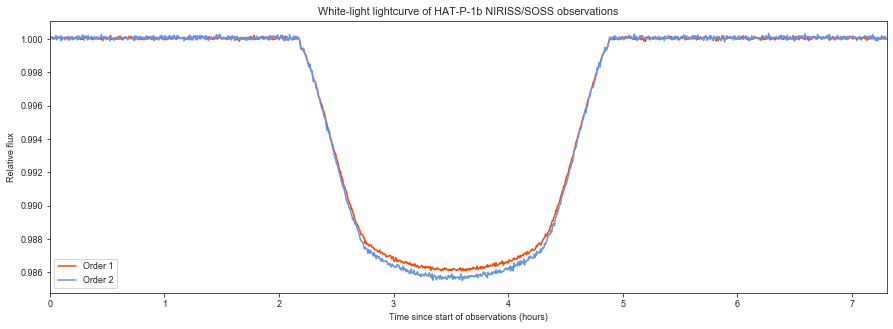

In [52]:
spec = pickle.load(open('spectra.pkl','rb'))
spectra = spec
NT = spec['order1']['flux'].shape[0]
lc_order1, lc_order2 = np.zeros(NT), np.zeros(NT)

# Indexes of uncontaminated spectra for Order 1 and 2:
idx_uncontaminated1 = np.where((spec['order1']['x'] < 300)|(spec['order1']['x'] > 1300))[0]
idx_uncontaminated2 = np.where(spec['order2']['x']  > 1300)[0]

# Sum the fluxes:
for i in range(NT):
    lc_order1[i] = np.sum(spec['order1']['flux'][i,idx_uncontaminated1])
    lc_order2[i] = np.sum(spec['order2']['flux'][i,idx_uncontaminated2])

# Save median-normalized lightcurves:    
spec['order1']['white-light'] = lc_order1/np.median(lc_order1)
spec['order2']['white-light'] = lc_order2/np.median(lc_order2)

# Plot
plt.figure(figsize=(15,5))    
plt.title('White-light lightcurve of HAT-P-1b NIRISS/SOSS observations')
thours = (spec['times']-spec['times'][0])*24
plt.plot(thours,spec['order1']['white-light'],color='orangered',label='Order 1')
plt.plot(thours,spec['order2']['white-light'],color='cornflowerblue',label='Order 2')
plt.legend()
plt.xlim(np.min(thours),np.max(thours))
plt.xlabel('Time since start of observations (hours)')
plt.ylabel('Relative flux')

Wow! Those look pretty good. There is a notable difference in the minimum fluxes here. Part of it can be attributed to limb-darkening (being Order 1 the order covering the reddest wavelengths, limb-darkening produces a more "box-shaped" lightcurve than for Order 2) --- but there is definetly somethig else going on. 

Let's now fit those transit lightcurves. We will fit them separately to see what we obtain from each order, compare and discuss the results. To perform the transit fitting, users can of course use any tool they want. In this notebook, we will use `juliet` (http://juliet.readthedocs.io/), which is a tool that allows to efficiently perform lightcurve fitting through Nested Sampling algorithms. 

We first import `juliet` and write the priors for the parameters of our fit. The parameters we will be fitting for are the period, $P$ (`P_p1`) of the orbit, the time-of-transit center $t_0$ (`t0_p1`), two parameters that parametrize the planet-to-star radius ratio $R_p/R_*$ and the impact parameter of the orbit $b = (a/R_*)\cos i$ in a unitary uniform plane, $r_1$ (`r1_p1`) and $r_2$ (`r2_p1` --- see [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta) for details), two parameters that parametrize the limb-darkening through a quadratic limb-darkening law, $q_1$ (`q1_SOSS`) and $q_2$ (`q2_SOSS` --- see [Kipping (2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.435.2152K/abstract)), the stellar density $\rho_*$ (`rho`), a scaling normalization factor for the out-of-transit flux (`mflux_SOSS`) and an unknown standard deviation added in quadrature to the errorbars of our data, `sigma_w_SOSS`. On top of this, we fix some parameters in our fit as well: we don't fit for the eccentricity $e$ (`ecc_p1`) or argument of periastron passage $\omega$ (`omega_p1`), as a single transit does not hold much information on these parameters. Similarly, we fix any possible dilution of the transit lightcurve by background sources (`mdilution_SOSS`) to 1, so we assume no dilution is in place. We take very wide priors for all the parameters that are left as free parameters in our fit except for the period, which we assume is well-known:

In [54]:
# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_SOSS','q2_SOSS','ecc_p1','omega_p1',\
              'rho', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform']

# Hyperparameters
hyperps = [[4.4652998,6e-7], [2459543.5,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [100., 10000.], 1.0, [0.,0.1], [0.1, 1000.]]

priors = juliet.generate_priors(params,dists,hyperps)

Having defined the parameters, priors and the hyperparameters of those priors, we now fit both datasets. For this, we pass the data in a `juliet`-friendly format:

In [55]:
for order in ['order1','order2']:
    times, fluxes, fluxes_error, norm_times = {},{},{}, {}
    times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = spec['times'],\
                                                          spec[order]['white-light'],\
                                                          np.ones(len(spec['times']))*1e-7
    
    # Load and fit dataset with juliet (save them to order*_juliet_results):
    spec[order]['dataset'] = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,\
                                yerr_lc = fluxes_error, out_folder = order+'_juliet_results')

    spec[order]['results'] = spec[order]['dataset'].fit(use_dynesty = True, dynamic = True, dynesty_nthreads=4)

Let's see how the fits look like:

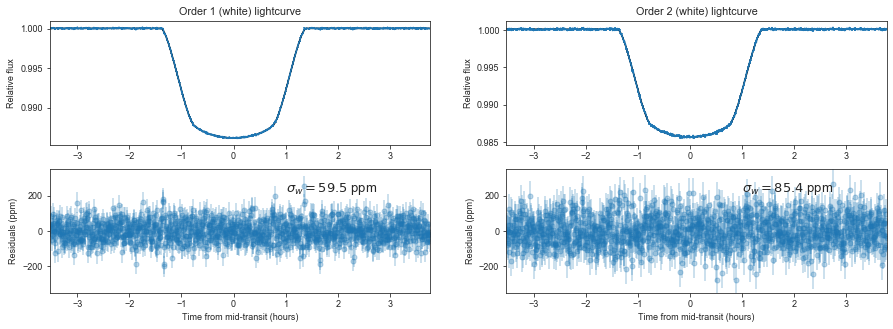

In [56]:
plt.figure(figsize=(15,5)) 
sns.set_style("ticks")

for i in [1,2]:
    plt.subplot('22'+str(i))
    plt.title('Order '+str(i)+' (white) lightcurve')
    order = 'order'+str(i)
    # First, extract estimated errorbars form our fits:
    sigma_w = np.median(spec[order]['results'].posteriors['posterior_samples']['sigma_w_SOSS'])
    spec[order]['sigma_w'] = sigma_w
    spec[order]['white-light_errors'] = np.ones(len(spec['times']))*sigma_w*1e-6
    # Extract estimated time-of-transit center:
    t0 = np.median(spec[order]['results'].posteriors['posterior_samples']['t0_p1'])
    # Normalize times to plot by this:
    tnorm = (spec['times']-t0)*24
    plt.errorbar(tnorm, spec[order]['white-light'], spec[order]['white-light_errors'],label='Data')
    # Plot best-fit model on top:
    spec[order]['model'] = spec[order]['results'].lc.evaluate('SOSS')
    plt.plot(tnorm, spec[order]['model'],color='black',label='Model')
    plt.xlim(np.min(tnorm),np.max(tnorm))
    plt.ylabel('Relative flux')
    # Residuals:
    plt.subplot('22'+str(i+2))
    spec[order]['residuals'] = spec[order]['white-light'] - spec[order]['model']
    plt.errorbar(tnorm, spec[order]['residuals']*1e6, spec[order]['white-light_errors']*1e6,fmt='o',alpha=0.3)
    plt.xlim(np.min(tnorm),np.max(tnorm))
    plt.ylim(-350,350)
    plt.text(1,220,r'$\sigma_w = {0:.1f}$ ppm'.format(sigma_w),fontsize=13)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel('Time from mid-transit (hours)')

Those look pretty good! The precisions more or less match what is expected from NIRISS/SOSS white-light lightcurves. 

### A.<font color='white'>-</font>Studying the residuals<a class="anchor" id="wl-residuals"></a>

One might wonder if there is any structure in the residuals. This structure can give rise to signals that, if not accounted for, might led us to believe we have a precision that is much better that what the dataset actually has to offer. A classic approach to performing a quick check on the residuals is to see if, as you bin more datapoints, their rms decreases with the square-root of the number of datapoints. If the data is distributed as gaussian random noise, then one should see a $1/\sqrt{N}$ decline in this plot, where $N$ is the number of datapoints in a given bin. This is an easy check to make in this case:

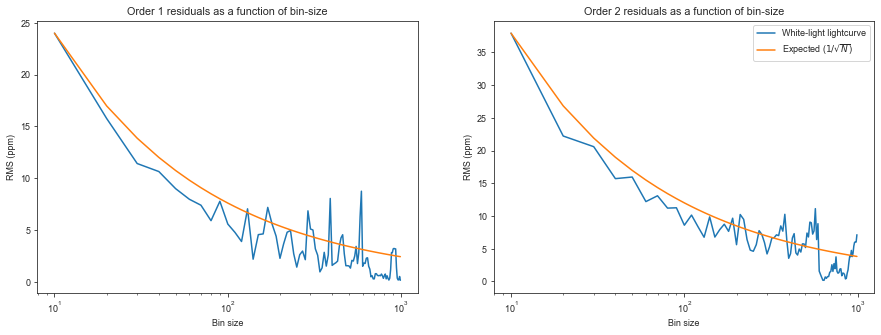

In [57]:
plt.figure(figsize=(15,5)) 
sns.set_style("ticks")

bin_sizes = np.arange(10,1000,10)
for i in [1,2]:
    order = 'order'+str(i)
    plt.subplot('12'+str(i))
    plt.title('Order '+str(i)+' residuals as a function of bin-size')
    rms = np.zeros(len(bin_sizes))
    for j in range(len(bin_sizes)):
        bin_size = bin_sizes[j]
        binned_times, binned_residuals, binned_errors = juliet.utils.bin_data(spec['times'],\
                                                                              spec[order]['residuals'],\
                                                                              bin_size)
        rms[j] = np.sqrt(np.var(binned_residuals))*1e6
    plt.plot(bin_sizes,rms,label='White-light lightcurve')
    plt.plot(bin_sizes,(np.sqrt(bin_sizes[0])*rms[0])/np.sqrt(bin_sizes),label='Expected ($1/\sqrt{N}$)')
    plt.xscale('log')
    #plt.yscale('log')
    plt.ylabel('RMS (ppm)')
    plt.xlabel('Bin size')
plt.legend()

In all honesty, the plots are not _that_ clear. The data (especially the one from Order 1) seems to go slightly below this $\sqrt{N}$ line, with some peaks at certain bin-sizes in which they go above it. It is unclear if these peaks say something meaningful or not. We turn, thus, to a second way of studying the residuals, which is always _my_ preferred way of studying them: analyzing the power spectrum of the residuals. This basically transforms the time-series to Fourier space where we can actually see if there is any evidence for residual signals at different time-scales/frequencies:

Maximum power: 0.0197, frequency: 15.81, FAP: 7.07%
Maximum power: 0.0107, frequency: 17.31, FAP: 100.00%


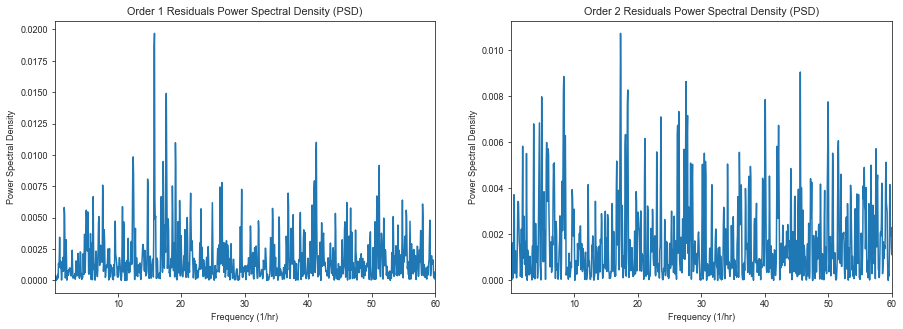

In [58]:
plt.figure(figsize=(15,5)) 
sns.set_style("ticks")

from astropy.timeseries import LombScargle
# Define frequencies in hours. From more or less the duration of the observation (~1 over 10 hours) to the 
# time-sampling (~1 over 1 minute, so over 1/60 hours)
frequency = np.linspace(1./10.,1./(1./60.), 1000)

for i in [1,2]:
    order = 'order'+str(i)
    plt.subplot('12'+str(i))
    plt.title('Order '+str(i)+' Residuals Power Spectral Density (PSD)')
    ls = LombScargle((spec['times']-spec['times'][0])*24, spec[order]['residuals'])
    psd = ls.power(frequency)
    max_power = np.max(psd)
    max_freq = frequency[np.where(max_power == psd)[0]][0]
    fap = ls.false_alarm_probability(max_power) 
    print('Maximum power: {0:.4f}, frequency: {1:.2f}, FAP: {2:.2f}%'.format(max_power,max_freq,fap*100))
    plt.plot(frequency,psd)
    plt.ylabel('Power Spectral Density')
    plt.xlabel('Frequency (1/hr)')
    plt.xlim([1./10.,60.])

This looks fairly good! There is only one peak at a similar frequency both in the Order 1 and Order 2 residuals: a signal at 15.81 and 17.31 hr$^{-1}$ or, roughly, at a period of about 3-4 minutes. However, the false alarm probabilities of those are fairly large ($>5 \%$) --- so the largest peaks are consistent with being due to random gaussian noise. We thus move ahead with that hypothesis, and assume there is no residual signal in our fits left o model.

**[Developer note: it might be good to check here the posterior distribution of the fits between the orders. A quick check shows there _are_ some differences in the orbital parameters. These most likely are due to the bugs identified above in the awesimsoss simulator that we are trying to solve.]**

4.<font color='white'>-</font>Fitting & analyzing the wavelength-dependant lightcurves<a class="anchor" id="wavelength"></a>
---------------------------------------------------------------------------------------


One of the main products that ought to be analyzed when observing transits with JWST are the wavelength-dependant lightcurves. Fitting those lets us obtain the final product of our observations: its transmission spectrum. To retrieve this, let us first fit the wavelength dependant lightcurves for each order:

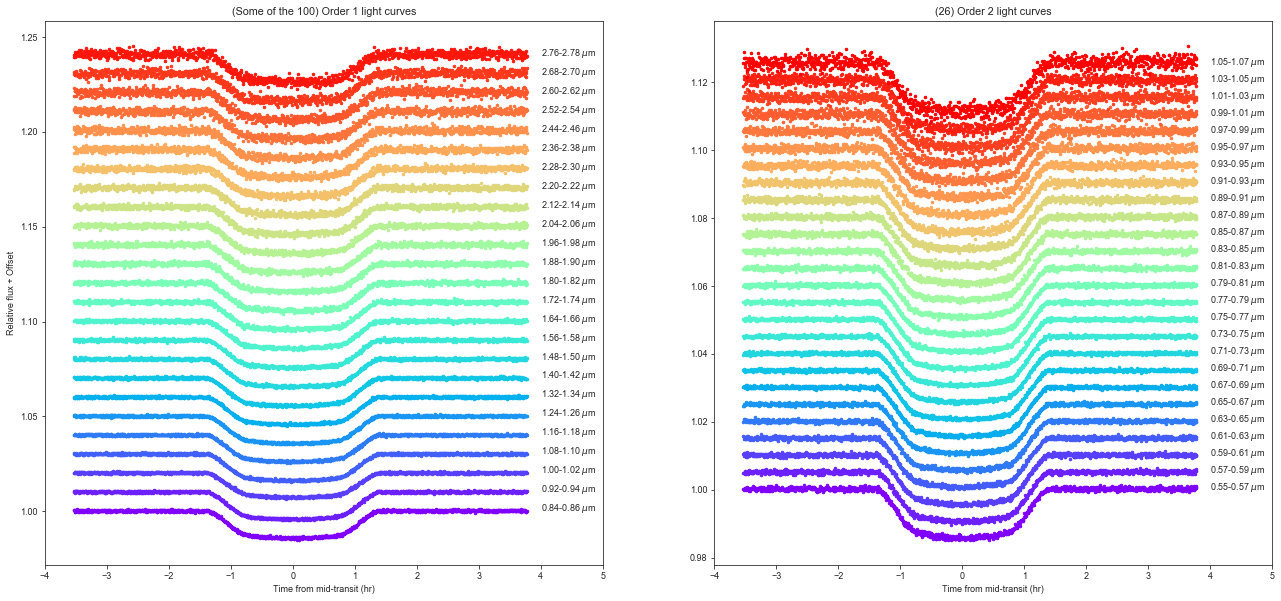

In [119]:
plt.figure(figsize=(22,10)) 
sns.set_style("ticks")
delta_w = 0.02

# Sum the fluxes on each of the bins. First for order 1:
counter = 0
plot_counter = 0
wbins = np.arange(np.min(spectra['order1']['w']),np.max(spectra['order1']['w']), delta_w)
color = plt.cm.rainbow(np.linspace(0,1,len(wbins)))
# Plot only a set of lightcurves to not overcrowd the plot:
idx_plot = np.arange(0,len(wbins),4)
plt.subplot(121)
for w,c in zip(wbins,color):
    spec['order1']['wbin'+str(counter)] = {}
    spec['order1']['wbin'+str(counter)]['w'] = w + delta_w*0.5
    spec['order1']['wbin'+str(counter)]['wmin'] = w 
    spec['order1']['wbin'+str(counter)]['wmax'] = w + delta_w
    idx = np.where((spec['order1']['w']>w)&(spec['order1']['w']<w+delta_w))[0]
    spec['order1']['wbin'+str(counter)]['lc'] = np.sum(spec['order1']['flux'][:,idx],axis=1)
    spec['order1']['wbin'+str(counter)]['lc'] = spec['order1']['wbin'+str(counter)]['lc']/np.median(spec['order1']['wbin'+str(counter)]['lc'])
    if counter in idx_plot:
        plt.plot((spectra['times']-t0)*24,spec['order1']['wbin'+str(counter)]['lc']+0.01*plot_counter,'.',color=c)
        plt.text(4, 1.+0.01*plot_counter, r'{0:.2f}-{1:.2f} $\mu$m'.format(w,w+delta_w))
        plot_counter += 1
    counter += 1
spec['order1']['nbins'] = counter
plt.xlim(-4,5)
plt.xlabel('Time from mid-transit (hr)')
plt.ylabel('Relative flux + Offset')
plt.title('(Some of the {}) Order 1 light curves'.format(spec['order1']['nbins']))

# And now for order 2:
counter = 0
wbins = np.arange(0.55,np.max(spectra['order2']['w']), delta_w)
color = plt.cm.rainbow(np.linspace(0,1,len(wbins)))
plt.subplot(122)
plt.title('({}) Order 2 light curves'.format(spec['order2']['nbins']))
for w,c in zip(wbins,color):
    spec['order2']['wbin'+str(counter)] = {}
    spec['order2']['wbin'+str(counter)]['w'] = w + delta_w*0.5
    spec['order2']['wbin'+str(counter)]['wmin'] = w 
    spec['order2']['wbin'+str(counter)]['wmax'] = w + delta_w
    idx = np.where((spec['order2']['w']>w)&(spec['order2']['w']<w+delta_w))[0]
    spec['order2']['wbin'+str(counter)]['lc'] = np.sum(spec['order2']['flux'][:,idx],axis=1)
    spec['order2']['wbin'+str(counter)]['lc'] = spec['order2']['wbin'+str(counter)]['lc']/np.median(spec['order2']['wbin'+str(counter)]['lc'])
    plt.plot((spectra['times']-t0)*24,spec['order2']['wbin'+str(counter)]['lc']+0.005*counter,'.',color=c)
    plt.text(4, 1.+0.005*counter, r'{0:.2f}-{1:.2f} $\mu$m'.format(w,w+delta_w))
    counter += 1
spec['order2']['nbins'] = counter
plt.xlim(-4,5)
plt.xlabel('Time from mid-transit (hr)')
#plt.ylabel('Relative flux')
plt.show()


And now, let's fit those lightcurves. To this end, we once again use `juliet` --- however, we fix the ephemerides and orbital parameters ($P$, $t_0$, $a/R_*$ and $b$) to those found in the white-light analysis, as they should be wavelength-independant. In our fits, thus, we only leave the transit depth, the limb-darkening coefficients, the out-of-transit flux and the "jitter" as free parameters:

In [120]:
# Name of the parameters to be fit:

params = ['P_p1','t0_p1','a_p1','b_p1','q1_SOSS','q2_SOSS','ecc_p1','omega_p1',\
              'p_p1', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed','fixed','fixed','fixed','uniform','uniform','fixed','fixed',\
                 'normal', 'fixed', 'normal', 'loguniform']

# Hyperparameters
hyperps = [4.4652997979, 2459543.6955160568, 10.22, 0.750273, [0., 1.], [0., 1.], 0.0, 90.,\
                   [0.,0.2], 1.0, [0.,0.1], [0.1, 1000.]]

priors = juliet.generate_priors(params,dists,hyperps)

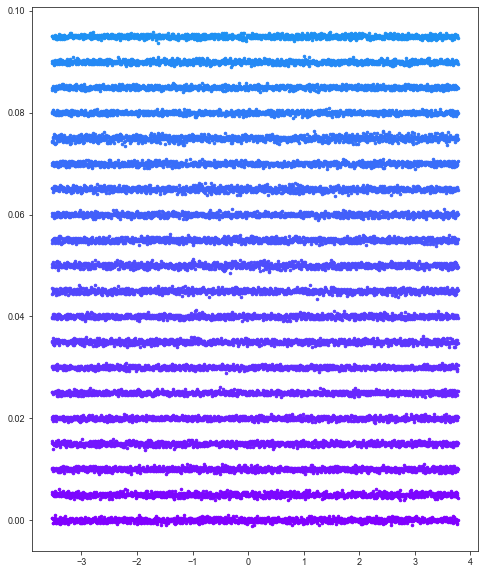

In [159]:
plt.figure(figsize=(8,10)) 
sns.set_style("ticks")

for order in ['order1','order2']:
    spec[order]['transmission_spectrum'] = {}
    spec[order]['transmission_spectrum']['wavelengths'] = np.array([])
    spec[order]['transmission_spectrum']['depths'] = np.array([])
    spec[order]['transmission_spectrum']['errors']= np.array([])
    color = plt.cm.rainbow(np.linspace(0,1,spec[order]['nbins']))
    counter = 0
    for i,c in zip(range(spec[order]['nbins']),color):
        times, fluxes, fluxes_error, norm_times = {},{},{}, {}
        times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = spec['times'],\
                                                          spec[order]['wbin'+str(i)]['lc'],\
                                                          np.ones(len(spec['times']))*1e-7
    
        # Load and fit dataset with juliet (save them to order*_juliet_results):
        spec[order]['dataset'] = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,\
                                    yerr_lc = fluxes_error, out_folder = order+'_wbin_'+str(i)+'_juliet_results')

        spec[order]['results'] = spec[order]['dataset'].fit()

        # Save transmission spectrum for plotting later:
        spec[order]['transmission_spectrum']['wavelengths'] = np.append(spec[order]['transmission_spectrum']['wavelengths'],\
                                                                        spec[order]['wbin'+str(i)]['w'])
        depths = ((spec[order]['results'].posteriors['posterior_samples']['p_p1'])**2)*1e6
        spec[order]['transmission_spectrum']['depths'] = np.append(spec[order]['transmission_spectrum']['depths'],\
                                                                   np.median(depths))
        spec[order]['transmission_spectrum']['errors'] = np.append(spec[order]['transmission_spectrum']['errors'], \
                           np.sqrt(np.var(depths)))
        
        # Plot lightcurve fits:
        if counter < 20 and order == 'order1':
            plt.plot((spectra['times']-t0)*24,spec[order]['wbin'+str(counter)]['lc']-spec[order]['results'].lc.evaluate('SOSS')+0.005*counter,'.',color=c)
            #plt.plot((spectra['times']-t0)*24,spec[order]['results'].lc.evaluate('SOSS')+0.005*counter,'-',color='black')
        counter += 1
    plt.show()
        

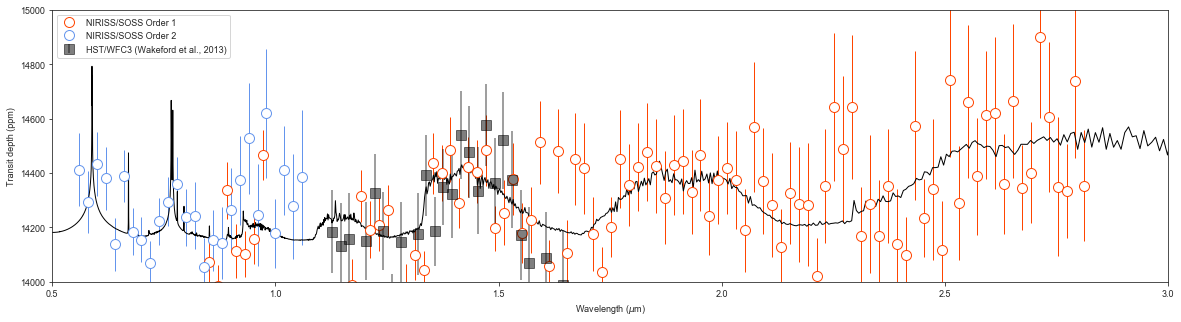

In [171]:
plt.figure(figsize=(20,5)) 
sns.set_style("ticks")

# Plot order 1 transit spectra:
plt.errorbar(spec['order1']['transmission_spectrum']['wavelengths'],\
             spec['order1']['transmission_spectrum']['depths'],\
             spec['order1']['transmission_spectrum']['errors'],\
             fmt='o',mfc='white',mec='orangered',ecolor='orangered',ms=10,elinewidth=1,label='NIRISS/SOSS Order 1')
# Same, order 2:
plt.errorbar(spec['order2']['transmission_spectrum']['wavelengths'],\
             spec['order2']['transmission_spectrum']['depths'],\
             spec['order2']['transmission_spectrum']['errors'],\
             fmt='o',mfc='white',mec='cornflowerblue',ecolor='cornflowerblue',ms=10,elinewidth=1,label='NIRISS/SOSS Order 2')

# HST data:
whst,rphst,rphst_err = np.loadtxt('hst.dat',unpack=True,usecols=(0,1,2))

depthhst,depthhst_err = np.zeros(len(whst)),np.zeros(len(whst))
for i in range(len(whst)):
    phst = np.random.normal(rphst[i],rphst_err[i],10000)
    dhst = (phst**2)*1e6
    depthhst[i],depthhst_err[i] = np.median(dhst),np.sqrt(np.var(dhst))

# Move HST data up to account from offset from JWST input model:
plt.errorbar(whst,depthhst+600,depthhst_err,fmt='s',color='black',ms=10,alpha=0.5,label='HST/WFC3 (Wakeford et al., 2013)')
wavelength_model, transit_depth_model = np.loadtxt('data/hp1_tspec.dat',unpack=True)
plt.plot(wavelength_model,transit_depth_model*1e6,color='black',lw=1)
plt.xlim(0.5,3.)
plt.ylim(14000,15000)
plt.ylabel('Transit depth (ppm)')
plt.xlabel('Wavelength ($\mu$m)')
plt.legend()
plt.show()
        

**[Developer note: the scatter in the final transit spectrum is a bit higher than expected. We are trying to track this down to a bug in the awesimsoss simulator]**